# Setup

In [1]:
!pip install kaskada

In [2]:
from kaskada.api.session import LocalBuilder
from kaskada import table as table

ksession = LocalBuilder().build()

INFO:kaskada.api.local_session.local_service:Initializing manager process
INFO:kaskada.api.local_session.local_service:Logging manager STDOUT to /home/jovyan/.cache/kaskada/logs/2023-07-21T14-13-34-manager-stdout.log
INFO:kaskada.api.local_session.local_service:Logging manager STDERR to /home/jovyan/.cache/kaskada/logs/2023-07-21T14-13-34-manager-stdout.log
INFO:kaskada.api.local_session.local_service:Initializing engine process
INFO:kaskada.api.local_session.local_service:Logging engine STDOUT to /home/jovyan/.cache/kaskada/logs/2023-07-21T14-13-34-engine-stdout.log
INFO:kaskada.api.local_session.local_service:Logging engine STDERR to /home/jovyan/.cache/kaskada/logs/2023-07-21T14-13-34-engine-stdout.log
INFO:kaskada.client:Successfully connected.


In [3]:
%load_ext fenlmagic

INFO:fenlmagic:extension loaded


In [4]:
from kaskada import table
try:
  table.delete_table("Transfer")

except:
  pass

table.create_table(
  table_name = "Transfer",
  entity_key_column_name = "TokenAddress",
  time_column_name = "BlockTimestamp",
)

# Load historical data
# Download from https://github.com/kerinin/ethereum-webinar/blob/main/transfers.parquet
table.load(table_name = "Transfer", file = "transfers.parquet")

data_token_id: "45690f72-1d9f-4181-9dd0-0220ac7fa0bc"
request_details {
  request_id: "833326141daeec5a6c5d6030a4b0b0f6"
}

In [5]:
%%fenl
Transfer

,_time,_subsort,_key_hash,_key,BlockTimestamp,TokenAddress,TokenID,FromAddress,ToAddress,Price,Quantity
0,2023-06-30 09:44:35,11838972086650901644,8195985840317330700,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,18,0x0dacb47e00aed6abade32c7b398e029393e0d848,0x8a3b85128d75b51383855e900c3a8182adc84deb,0.00000,1
1,2023-06-30 09:44:35,11838972086650901645,8195985840317330700,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,18,0x0dacb47e00aed6abade32c7b398e029393e0d848,0x7f3454fe843455fb7d0ac071d0177c2a6554efee,0.00000,1
2,2023-06-30 09:44:35,11838972086650901646,8195985840317330700,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,18,0x0dacb47e00aed6abade32c7b398e029393e0d848,0x666e1a01abe04e91963e5d41382115cdc84ec643,0.00000,1
3,2023-06-30 09:44:35,11838972086650901647,8195985840317330700,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,18,0x0dacb47e00aed6abade32c7b398e029393e0d848,0xbabe2a0486aeceb3ffa4957f5cfdc85763130140,0.00000,1
4,2023-06-30 09:44:35,11838972086650901648,8195985840317330700,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,18,0x0dacb47e00aed6abade32c7b398e029393e0d848,0x1b0cf9fe79c9298b2364ad1f4d9c085a4974970c,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...
1029395,2023-07-09 16:00:11,11838972086650474177,800380581071333790,0x703e54bb5e5e03db13678af8fd6357348fa35d15,2023-07-09 16:00:11,0x703e54bb5e5e03db13678af8fd6357348fa35d15,5820,0xaeb0a20c5af6e903f0adf432b3a689c2b242d47c,0xa7d36b6ea53ad62357cd7866df953957928b7694,0.13979,1
1029396,2023-07-09 16:00:11,11838972086650474178,800380581071333790,0x703e54bb5e5e03db13678af8fd6357348fa35d15,2023-07-09 16:00:11,0x703e54bb5e5e03db13678af8fd6357348fa35d15,2374,0xd4c3b2c29bb06483413a5a6d6d5cf3e22d04d349,0x93a87f58270aff6783a3bbd1dbacfae82f3dcf96,0.20228,1
1029397,2023-07-09 16:00:11,11838972086650474179,800380581071333790,0x703e54bb5e5e03db13678af8fd6357348fa35d15,2023-07-09 16:00:11,0x703e54bb5e5e03db13678af8fd6357348fa35d15,1472,0xd4c3b2c29bb06483413a5a6d6d5cf3e22d04d349,0x93a87f58270aff6783a3bbd1dbacfae82f3dcf96,0.20228,1
1029398,2023-07-09 16:00:11,11838972086650474180,800380581071333790,0x703e54bb5e5e03db13678af8fd6357348fa35d15,2023-07-09 16:00:11,0x703e54bb5e5e03db13678af8fd6357348fa35d15,1471,0xd4c3b2c29bb06483413a5a6d6d5cf3e22d04d349,0x93a87f58270aff6783a3bbd1dbacfae82f3dcf96,0.20228,1


# Feature Engineering

Try building some features

* Target value - the price of each transfer
* Limit to just the transfers you care about - where the sender is empty ("0x0000000000000000000000000000000000000000")
* Add a simple feature - the average price of NFT's in the same group
* Limit that to recent prices
* See if the quantity matters
* The buyer's behavior may matter - pull in the average price paid by the buyer (the to-address)

In [16]:
%%fenl --var input_features_df
{
    target: Transfer.Price | last(),
}

,_time,_subsort,_key_hash,_key,target
0,2023-06-30 09:44:35,11838972086650901644,8195985840317330700,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,0.00000
1,2023-06-30 09:44:35,11838972086650901645,8195985840317330700,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,0.00000
2,2023-06-30 09:44:35,11838972086650901646,8195985840317330700,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,0.00000
3,2023-06-30 09:44:35,11838972086650901647,8195985840317330700,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,0.00000
4,2023-06-30 09:44:35,11838972086650901648,8195985840317330700,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,0.00000
...,...,...,...,...,...
1029395,2023-07-09 16:00:11,11838972086650474177,800380581071333790,0x703e54bb5e5e03db13678af8fd6357348fa35d15,0.13979
1029396,2023-07-09 16:00:11,11838972086650474178,800380581071333790,0x703e54bb5e5e03db13678af8fd6357348fa35d15,0.20228
1029397,2023-07-09 16:00:11,11838972086650474179,800380581071333790,0x703e54bb5e5e03db13678af8fd6357348fa35d15,0.20228
1029398,2023-07-09 16:00:11,11838972086650474180,800380581071333790,0x703e54bb5e5e03db13678af8fd6357348fa35d15,0.20228


Root Mean Squared Error (RMSE): 51.005186419355084
         avg_purchase
509857       0.173323
485448       0.000401
358388       0.000686
99800        0.000000
232665       0.000000
...               ...
618034       0.000000
613033       0.000000
1011838      0.000000
819188       0.000000
199942       0.000266

[10000 rows x 1 columns]


(0.0, 18.0)

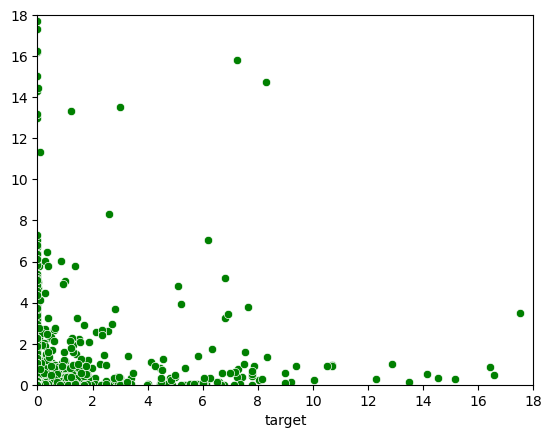

In [15]:
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.ensemble as se
import pickle


# Split input DF into features and labels so we can easily pass to test_train_split for housekeeping
X = input_features_df.dataframe.drop(["target", "_key", "_key_hash", "_subsort", "_time"], axis=1)
y = input_features_df.dataframe["target"]

# model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, train_size=50000, random_state=1205)
rf = se.RandomForestRegressor(n_estimators=100, random_state=1205)
rf.fit(X_train, y_train)

# model performance eval
y_pred = rf.predict(X_test)

print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(X_test)

g = sns.scatterplot(x=y_test , y=y_pred, color="green")
g.set_xlim(0, 18)

g.set_ylim(0, 18)

# Inference

In [ ]:
%%fenl --result-behavior final-results
let mean_recipient_price = Transfer.Price | with_key(Transfer.ToAddress) | mean()
in {
    mrp: mean_recipient_price | lookup(Transfer.ToAddress),
    avg_price: Transfer.Price | mean(window=sliding(10, is_valid(Transfer))),
    avg_purchase: (Transfer.Price * (Transfer.Quantity as i64)) | mean() | else(0),
}

,_time,_subsort,_key_hash,_key,mrp,avg_price,avg_purchase
0,2023-07-09 16:00:11.000000001,18446744073709551615,2036701356705116,0x5537d90a4a2dc9d9b37bab49b490cf67d4c54e91,0.380977,0.004250,0.004250
1,2023-07-09 16:00:11.000000001,18446744073709551615,3307527983046435,0xe987e9b07ca431fe0c7e8f431fa4f94ab9ca2423,0.012500,0.005970,0.005970
2,2023-07-09 16:00:11.000000001,18446744073709551615,4994706956932475,0x10064373e248bc7253653ca05df73cf226202956,0.001500,0.002590,0.006720
3,2023-07-09 16:00:11.000000001,18446744073709551615,8987872330389580,0x730b6e13e58a0e21d85f1e978b4422eb2da63157,0.122000,0.443130,0.170435
4,2023-07-09 16:00:11.000000001,18446744073709551615,9428993676166877,0x705524313fab8d816c73bcdb778962d42dfe6cb4,0.002356,0.010564,0.095043
...,...,...,...,...,...,...,...
13552,2023-07-09 16:00:11.000000001,18446744073709551615,18439387020786770804,0x8bb176834a5d5f010ed2fa3f91faa4c3a038f6b8,0.000000,0.000000,0.000000
13553,2023-07-09 16:00:11.000000001,18446744073709551615,18439521042008277419,0x5142db5ef0f5196b26d08053ee56c90530c69f88,0.040621,0.000000,0.000000
13554,2023-07-09 16:00:11.000000001,18446744073709551615,18439979463093779972,0x548bb4f3675fee180f272bb90ffcb00b827c1b05,0.014500,0.008400,0.008143
13555,2023-07-09 16:00:11.000000001,18446744073709551615,18444109377158748958,0x6976af8b25c97a090769fa97ca9359c891353f61,0.027933,0.017867,0.017867


## Some example features

In [11]:
%%fenl
# The average price paid by a given address
let mean_buyer_price = Transfer.Price | with_key(Transfer.ToAddress) | mean()

in {
    # What the buyer of this token generally pays for NFT's.
    mbp: mean_buyer_price | lookup(Transfer.ToAddress),
    
    # Thast price paid for NFT's in the same group (ie all bored apes)
    last_transfer: Transfer.Price | lag(1) | else(0),
    
    # The average price paid for the 10 most recenet NFT's in the same group
    avg_price: Transfer.Price | mean(window=sliding(10, is_valid(Transfer))),
    
    # The average transaction avlue for NFT's in the same group
    avg_purchase: (Transfer.Price * (Transfer.Quantity as i64)) | mean() | else(0),
    
    # The amount paid for each transfer
    target: Transfer.Price | last(),
}

# Limit examples to rows without a send - ie, initial NFT purchases.
| when(Transfer.FromAddress == "0x0000000000000000000000000000000000000000")

,_time,_subsort,_key_hash,_key,mbp,last_transfer,avg_price,avg_purchase,target
0,2023-06-30 09:44:47,11838972086650901628,8923845538025406707,0xecf79dc580fbc8e322f060465fb4227af64e8cfc,0.0000,0.0000,0.00000,0.000000,0.0000
1,2023-06-30 09:44:47,11838972086650901629,15748564441512563745,0x68b9c676b21e24b7bda336fc048021339bbb3382,0.0000,0.0000,0.00000,0.000000,0.0000
2,2023-06-30 09:44:47,11838972086650901630,228803242140079054,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.0000,0.0000,0.00000,0.000000,0.0000
3,2023-06-30 09:44:47,11838972086650901631,228803242140079054,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.0000,0.0000,0.00000,0.000000,0.0000
4,2023-06-30 09:44:47,11838972086650901632,228803242140079054,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.0000,0.0000,0.00000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...
581292,2023-07-09 15:59:59,11838972086650474183,9090603029681058686,0x32973908faee0bf825a343000fe412ebe56f802a,0.0000,0.0000,0.10064,0.065267,0.0000
581293,2023-07-09 15:59:59,11838972086650474185,9090603029681058686,0x32973908faee0bf825a343000fe412ebe56f802a,0.0000,0.0000,0.10064,0.065085,0.0000
581294,2023-07-09 16:00:11,11838972086650474170,1014080309187626310,0x427b8efee2d6453bb1c59849f164c867e4b2b376,0.0000,0.0000,0.00000,0.000837,0.0000
581295,2023-07-09 16:00:11,11838972086650474171,17902620311814727414,0xfe1930dfc30673bc1f5c385363b7803911f2bb05,0.0000,0.0000,0.00000,0.000000,0.0000
